In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
from IPython.display import display, HTML
show_html = lambda html: display(HTML(html))

In [2]:
import apafib
data = apafib.load_column()
target_names=['DH', 'SL', 'NO']

In [3]:
data.head()

,pelvic_incidence,pelvic_tilt,lumbar_lordosis_angle,sacral_slope,pelvic_radius,degree_spondylolisthesis,class
0,63.03,22.55,39.61,40.48,98.67,-0.25,DH
1,39.06,10.06,25.02,29.00,114.41,4.56,DH
2,68.83,22.22,50.09,46.61,105.99,-3.53,DH
3,69.30,24.65,44.31,44.64,101.87,11.21,DH
4,49.71,9.65,28.32,40.06,108.17,7.92,DH


In [4]:
data.describe(include='all').T

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
pelvic_incidence,310.0,NaN,NaN,NaN,60.496484,17.236109,26.15,46.4325,58.69,72.88,129.83
pelvic_tilt,310.0,NaN,NaN,NaN,17.542903,10.00814,-6.55,10.6675,16.36,22.12,49.43
lumbar_lordosis_angle,310.0,NaN,NaN,NaN,51.93071,18.553766,14.0,37.0,49.565,63.0,125.74
sacral_slope,310.0,NaN,NaN,NaN,42.953871,13.422748,13.37,33.3475,42.405,52.6925,121.43
pelvic_radius,310.0,NaN,NaN,NaN,117.920548,13.317629,70.08,110.71,118.265,125.4675,163.07
degree_spondylolisthesis,310.0,NaN,NaN,NaN,26.296742,37.558883,-11.06,1.6,11.765,41.285,418.54
class,310,3,SL,150,NaN,NaN,NaN,NaN,NaN,NaN,NaN


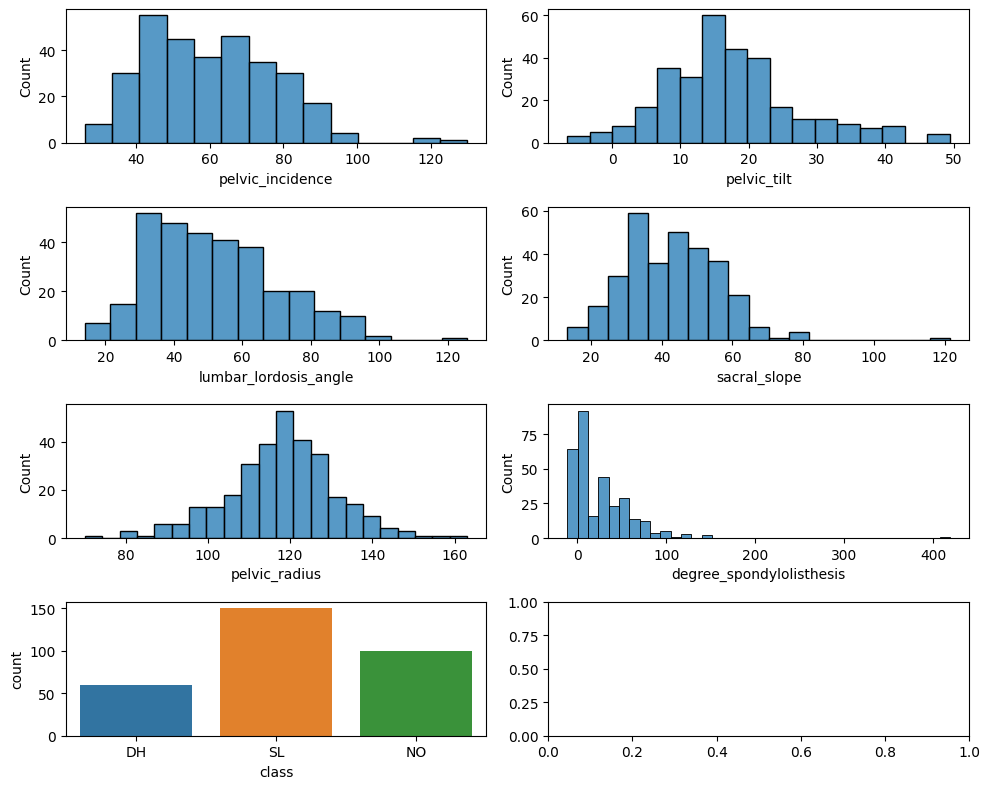

In [5]:
fig, axes = plt.subplots(4,2,figsize=(10,8))
for i, c in enumerate(data.columns[:15]):
    ax = axes.reshape(-1)[i]
    if data[c].dtype.kind == 'O':
        a = sns.countplot(x=c,data=data,ax=ax)
    else:
        b = sns.histplot(x=c,data=data,ax=ax)
plt.tight_layout()

In [6]:
X = data.drop('class',axis=1)
y = data['class']

In [7]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

In [8]:
from sklearn.preprocessing import MinMaxScaler
scaler = MinMaxScaler()

X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

In [9]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import  ConfusionMatrixDisplay,\
                    classification_report,  RocCurveDisplay, PrecisionRecallDisplay,\
                    accuracy_score, f1_score, precision_score, recall_score


In [10]:
from sklearn.linear_model import LogisticRegression
lr = LogisticRegression(max_iter=10000)
lr.fit(X_train_s,y_train)
print(np.mean(cross_val_score(lr,X_train_s,y_train,cv=10)))

param = {'penalty':['l2'], 'C':10**np.linspace(-3,3,21, endpoint=True)}
lr_gs =  GridSearchCV(lr,param,cv=10, n_jobs=-1, refit=True)
lr_gs.fit(X_train_s, y_train)

0.743073593073593


GridSearchCV(cv=10, estimator=LogisticRegression(max_iter=10000), n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 1.99526231e-03, 3.98107171e-03, 7.94328235e-03,
       1.58489319e-02, 3.16227766e-02, 6.30957344e-02, 1.25892541e-01,
       2.51188643e-01, 5.01187234e-01, 1.00000000e+00, 1.99526231e+00,
       3.98107171e+00, 7.94328235e+00, 1.58489319e+01, 3.16227766e+01,
       6.30957344e+01, 1.25892541e+02, 2.51188643e+02, 5.01187234e+02,
       1.00000000e+03]),
                         'penalty': ['l2']})

In [11]:
show_html(pd.DataFrame(lr_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
20,"{'C': 1000.0, 'penalty': 'l2'}",0.871861,1
18,"{'C': 251.18864315095772, 'penalty': 'l2'}",0.867100,2
17,"{'C': 125.89254117941663, 'penalty': 'l2'}",0.867100,2
16,"{'C': 63.0957344480193, 'penalty': 'l2'}",0.867100,2
19,"{'C': 501.18723362727246, 'penalty': 'l2'}",0.862554,5


In [12]:
print(classification_report(lr_gs.predict(X_test_s),y_test))

              precision    recall  f1-score   support

          DH       0.50      0.77      0.61        13
          NO       0.83      0.71      0.77        35
          SL       0.98      0.93      0.95        45

    accuracy                           0.83        93
   macro avg       0.77      0.81      0.78        93
weighted avg       0.86      0.83      0.84        93



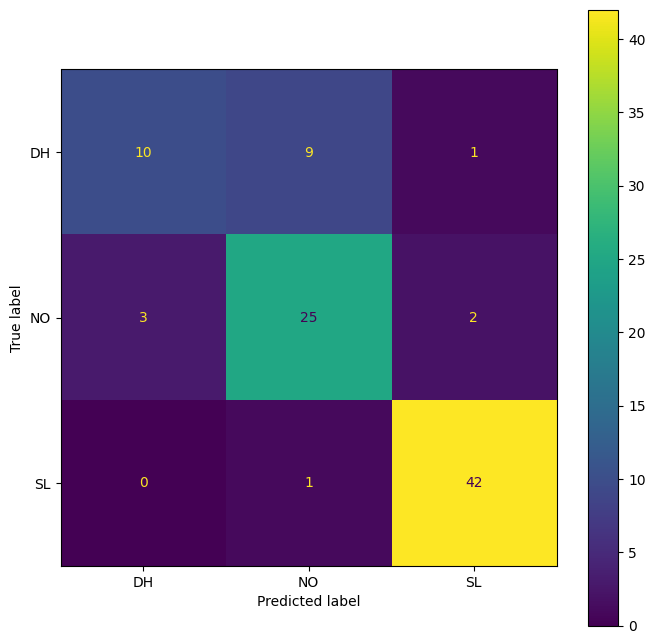

In [13]:
plt.figure(figsize=(8,8));
ConfusionMatrixDisplay.from_estimator(lr_gs, X_test_s, y_test, ax=plt.subplot())

In [14]:
from sklearn.svm import SVC
param = {'C':10**np.linspace(-3,3,101)}

psvc = SVC(kernel='poly', max_iter=1000000, random_state=0)
psvc_gs = GridSearchCV(psvc,param,cv=5, n_jobs=-1, refit=True)
psvc_gs.fit(X_train_s, y_train)

rsvc = SVC(kernel='rbf', max_iter=1000000, random_state=0)
rsvc_gs = GridSearchCV(rsvc,param,cv=5, n_jobs=-1, refit=True)
rsvc_gs.fit(X_train_s, y_train)

GridSearchCV(cv=5, estimator=SVC(max_iter=1000000, random_state=0), n_jobs=-1,
             param_grid={'C': array([1.00000000e-03, 1.14815362e-03, 1.31825674e-03, 1.51356125e-03,
       1.73780083e-03, 1.99526231e-03, 2.29086765e-03, 2.63026799e-03,
       3.01995172e-03, 3.46736850e-03, 3.98107171e-03, 4.57088190e-03,
       5.24807460e-03, 6.02559586e-03, 6.91830971e-03, 7.94328235e-03,
       9.12010839e-...
       3.63078055e+01, 4.16869383e+01, 4.78630092e+01, 5.49540874e+01,
       6.30957344e+01, 7.24435960e+01, 8.31763771e+01, 9.54992586e+01,
       1.09647820e+02, 1.25892541e+02, 1.44543977e+02, 1.65958691e+02,
       1.90546072e+02, 2.18776162e+02, 2.51188643e+02, 2.88403150e+02,
       3.31131121e+02, 3.80189396e+02, 4.36515832e+02, 5.01187234e+02,
       5.75439937e+02, 6.60693448e+02, 7.58577575e+02, 8.70963590e+02,
       1.00000000e+03])})

In [15]:
show_html(pd.DataFrame(psvc_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())
show_html(pd.DataFrame(rsvc_gs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())

,params,mean_test_score,rank_test_score
56,{'C': 2.2908676527677723},0.889746,1
55,{'C': 1.9952623149688788},0.889641,2
58,{'C': 3.019951720402016},0.884989,3
51,{'C': 1.1481536214968828},0.880444,4
54,{'C': 1.7378008287493745},0.880444,4


,params,mean_test_score,rank_test_score
62,{'C': 5.248074602497723},0.871247,1
64,{'C': 6.918309709189363},0.871247,1
66,{'C': 9.120108393559097},0.866702,3
63,{'C': 6.025595860743575},0.866596,4
69,{'C': 13.803842646028839},0.862156,5


In [16]:
print(classification_report(psvc_gs.predict(X_test_s), y_test))
print(); print()
print(classification_report(rsvc_gs.predict(X_test_s), y_test))

              precision    recall  f1-score   support

          DH       0.50      0.59      0.54        17
          NO       0.70      0.68      0.69        31
          SL       0.98      0.93      0.95        45

    accuracy                           0.78        93
   macro avg       0.73      0.73      0.73        93
weighted avg       0.80      0.78      0.79        93



              precision    recall  f1-score   support

          DH       0.55      0.58      0.56        19
          NO       0.70      0.68      0.69        31
          SL       0.95      0.95      0.95        43

    accuracy                           0.78        93
   macro avg       0.73      0.74      0.74        93
weighted avg       0.79      0.78      0.79        93



son iguals xd, agafem el polynomic

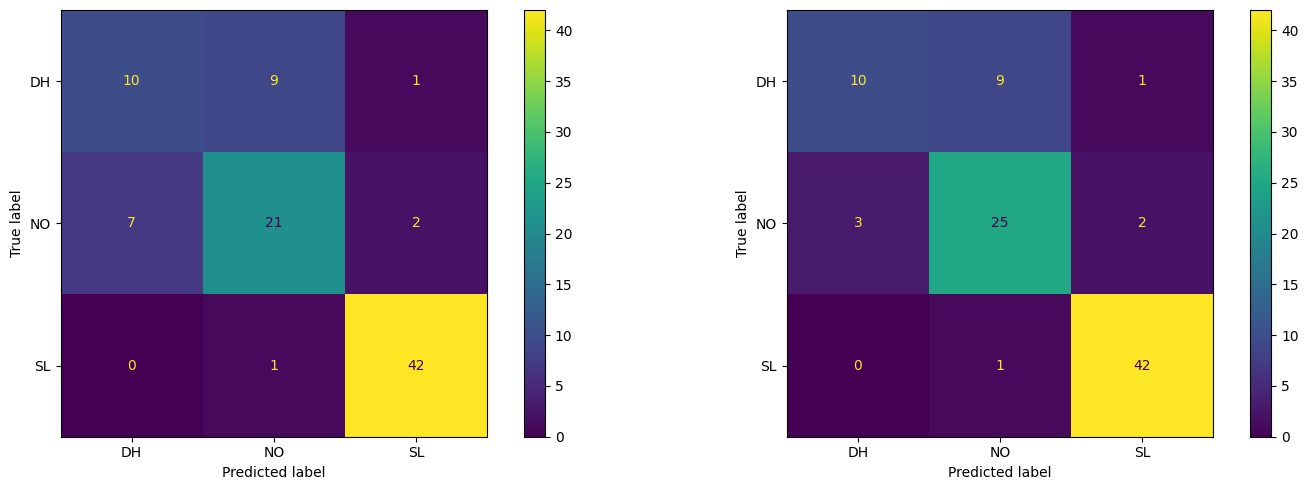

In [17]:
fig, axes = plt.subplots(1,2,figsize=(15,5))
ax = axes.reshape(-1)[0]
ConfusionMatrixDisplay.from_estimator(psvc_gs, X_test_s, y_test, ax=ax)
ax = axes.reshape(-1)[1]
ConfusionMatrixDisplay.from_estimator(lr_gs, X_test_s, y_test, ax=ax)
plt.tight_layout()

alto cap lr

In [18]:
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from skopt import BayesSearchCV
from sklearn.model_selection import RandomizedSearchCV

In [19]:
rf = RandomForestClassifier(random_state=0)
print(np.mean(cross_val_score(rf,X_train_s,y_train,cv=10)))

param = {'n_estimators':[10,100, 200],
         'min_samples_split': [2,4,32],
         'min_samples_leaf': [2,4,32],
         'max_features': [1,2,32]
         }

rf=RandomForestClassifier(warm_start=True, random_state=0)
rf_bs =  BayesSearchCV(rf,param,n_iter=15, cv=5, n_jobs=-1, refit=True, random_state=0)
rf_bs.fit(X_train_s, y_train);
show_html(pd.DataFrame(rf_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())
print(classification_report(rf_bs.predict(X_test_s), y_test))

0.8621212121212121


,params,mean_test_score,rank_test_score
12,"{'max_features': 32, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 100}",0.871142,1
14,"{'max_features': 32, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 100}",0.871142,1
0,"{'max_features': 2, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 100}",0.861945,3
9,"{'max_features': 2, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 200}",0.848097,4
2,"{'max_features': 2, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 10}",0.843552,5


              precision    recall  f1-score   support

          DH       0.50      0.71      0.59        14
          NO       0.80      0.69      0.74        35
          SL       0.95      0.93      0.94        44

    accuracy                           0.81        93
   macro avg       0.75      0.78      0.76        93
weighted avg       0.83      0.81      0.81        93



In [22]:
gb =  GradientBoostingClassifier(random_state=0,n_iter_no_change=5)
print(np.mean(cross_val_score(gb,X_train_s,y_train,cv=10)))

param = {'n_estimators': [5,10,25,40, 50, 75,100, 200], 
        #  'loss':['log_loss', 'exponential'], 
         'criterion':['friedman_mse', 'squared_error'], 
         'max_depth':[None, 1, 2, 3,  5,  8, 9,10,15],
         'min_samples_leaf':[1,2,3,5,10], 
         'learning_rate':[0.1,0.5, 1,3, 5, 10, 15]}

gb_bs =  BayesSearchCV(gb,param,n_iter=15, cv=5, n_jobs=-1, refit=True, random_state=0)
gb_bs.fit(X_train_s, y_train);
show_html(pd.DataFrame(gb_bs.cv_results_).loc[:,['params', 'mean_test_score','rank_test_score']].sort_values(by='rank_test_score').head().to_html())
print(classification_report(gb_bs.predict(X_test_s), y_test))

0.8339826839826842


,params,mean_test_score,rank_test_score
4,"{'criterion': 'friedman_mse', 'learning_rate': 0.5, 'max_depth': 9, 'min_samples_leaf': 2, 'n_estimators': 10}",0.852748,1
7,"{'criterion': 'squared_error', 'learning_rate': 3.0, 'max_depth': 9, 'min_samples_leaf': 1, 'n_estimators': 5}",0.843446,2
2,"{'criterion': 'squared_error', 'learning_rate': 0.1, 'max_depth': 3, 'min_samples_leaf': 2, 'n_estimators': 25}",0.843340,3
12,"{'criterion': 'squared_error', 'learning_rate': 0.5, 'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 10}",0.834355,4
14,"{'criterion': 'friedman_mse', 'learning_rate': 0.5, 'max_depth': 9, 'min_samples_leaf': 5, 'n_estimators': 10}",0.834249,5


              precision    recall  f1-score   support

          DH       0.40      0.53      0.46        15
          NO       0.73      0.65      0.69        34
          SL       0.95      0.93      0.94        44

    accuracy                           0.76        93
   macro avg       0.70      0.70      0.70        93
weighted avg       0.78      0.76      0.77        93

